# Analysis of ABCtoolbox results

ABCtoolbox output includes:  
- retained simulations
- marginal posterior densities
- marginal posterior densities charecterisitcs
- joint posterior densities

In this Notebook, I:
- reformat the marginal posterior densities charecterisitcs file so it is easily readable
- plot a heatmap of the joint posterior densities
- calculate the probability NEA > NWA
- plot the marginal priors, truncated priors, and posterior denstities

## Setup code

In [2]:
import sys, os
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/anaconda3/bin/python
3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [3]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

NameError: name '__file__' is not defined

In [161]:
%%bash
# sudo /opt/anaconda3/bin/conda install rpy2
# sudo /opt/anaconda3/bin/conda install -c conda-forge ggplot

In [1]:
from sys import argv
import pandas as pd
# from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True, style="ticks")
import numpy as np
# import rpy2
# %load_ext rpy2.ipython

## Functions

In [148]:
def read_abc_config(abc_config_name):
    """
    Get input files used for ABC and results files output by ABC.
    :param abc_config_name: The configuration file used to run ABCtoolbox 
    :return: simName:
    :return: obsName:
    :return: outputPrefix:
    """

    simName = ""
    obsName = ""
    outputPrefix = ""

    if os.path.isfile(abc_config_name):
        print(abc_config_name)
        abc_config = open(abc_config_name, 'r')
        for line in abc_config:
            line_lst = line.split()
            arg = line_lst[0]
            if arg == "simName":
                simName = line.split()[1]
            if arg == "obsName":
                obsName = line.split()[1]
            if arg == "outputPrefix":
                outputPrefix = line.split()[1]
            if arg == "params":
                params_str = line.split()[1]
        abc_config.close()
    else:
        print('{} does not exist'.format(abc_config_name))
        exit()

    if not simName:
        print("simName not included in ABCtoolbox config file")
        exit()
    if not obsName:
        print("obsName not included in ABCtoolbox config file")
        exit()
    if not outputPrefix:
        print("outputPrefix not included in ABCtoolbox config file")
        exit()

    return [simName, obsName, outputPrefix, params_str]


def get_results_files(outputPrefix):
    """
    Define names of ABCtoolbox estimate results files
    :param outputPrefix: the output prefix provided in the ABCtoolbox config file
    :return: names of ABCtoolbox output files
    """

    BestSimsParamStats_name = '{}model0_BestSimsParamStats_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorDensities_name = '{}model0_MarginalPosteriorDensities_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorCharacteristics_name = '{}model0_MarginalPosteriorCharacteristics.txt'.format(outputPrefix)
    jointPosterior_name = '{}model0_jointPosterior_8_9_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorCharacteristics_reformat_name = '{}model0_MarginalPosteriorCharacteristicsReformat.txt'.format(outputPrefix)
    modelFit_name = '{}modelFit.txt'.format(outputPrefix)

    
    return [BestSimsParamStats_name,
            MarginalPosteriorDensities_name,
            MarginalPosteriorCharacteristics_name,
            jointPosterior_name,
            MarginalPosteriorCharacteristics_reformat_name,
           modelFit_name]


def get_modelchocie_files(outputPrefix):
    """
    Define names of ABCtoolbox model choice
    :param outputPrefix: the output prefix provided in the ABCtoolbox config file
    :return: names of ABCtoolbox output files
    """
    
    confusionMatrix_name = '{}confusionMatrix.txt'.format(outputPrefix)
    modelChoiceValidation_name = '{}modelChoiceValidation.txt'.format(outputPrefix)
    modelFit_name = '{}modelFit.txt'.format(outputPrefix)
    
    return [confusionMatrix_name,
           modelChoiceValidation_name,
           modelFit_name]
    

def reformat_Characteristics(MarginalPosteriorCharacteristics_name):
    """
    reformat the ABCtoolbox output file MarginalPosteriorCharacteristics to a table with parameter as the rows and
     posterior density characteristics as columns.
    :param MarginalPosteriorCharacteristics_name: file name of ABCtoolbox output file with characteristics of posterior
    density.
    :return: df_table: pandas dataframe with parameters as rows and posterior density characteristics as columns
    """

    characteristics = ['mode', 'mean', 'median', 'q50_lower', 'q50_upper', 'q90_lower', 'q90_upper', 'q95_lower', 'q95_upper',
                  'q99_lower', 'q99_upper', 'HDI50_lower', 'HDI50_upper', 'HDI90_lower', 'HDI90_upper', 'HDI95_lower',
                  'HDI95_upper', 'HDI99_lower', 'HDI99_upper']
    n_chars = len(characteristics)

    if os.path.isfile(MarginalPosteriorCharacteristics_name):
        print('parsing {}'.format(MarginalPosteriorCharacteristics_name))

        df = pd.read_csv(MarginalPosteriorCharacteristics_name, sep = '\t').drop('dataSet', 1)
        header = list(df)

        df_list = []
        start = 0
        for i in range(1, int(len(df.columns)/n_chars)):
            param = header[start].split(characteristics[0])[0].strip('_')
            df_param = df.loc[:, header[start]:header[start + n_chars - 1]]
            df_param.columns = characteristics
            df_param['param'] = param
            df_param.set_index('param')
            df_list.append(df_param)
            start = n_chars * i
        df_table = pd.concat(df_list)

    else:
        print('{} does not exist'.format(MarginalPosteriorCharacteristics_name))
        print('Did you run ABCtoolbox in this directory?')
        exit()

    return df_table


def get_param_indexes(params_str):
    """
    Convert string of parameter column numbers into list of ints
    :param params_str: string of parameter column numbers from the ABCtoolbox config file, of the form: 1-5,9-12
    :return: get_param_indexes: list of ints
    """
    param_indexes = []
    ranges = params_str.split(',')
    for values in ranges:
        x = int(values.split('-')[0].strip()) - 1
        y = int(values.split('-')[1].strip())
        param_indexes.extend(list(range(x, y)))
    return param_indexes


def get_col_names(ints, df):
    """
    Get list of column names of a dataframe from list of ints
    :param ints: list of integers
    :param df: dataframe with column names
    :return: names: list of column names
    """
    
    names = []
    for i in ints:
        names.append(list(df)[i])
    return names


def plot_param_densities(posterior, truncated, prior, df_chrs_reformat, param):
    """
    Use matplotlib and seaborn to plot prior, truncated, and posterior distributions of parameter.
    :param posterior: dataframe of ABCtoolbox *MarginalPosteriorDensities_Obs0.txt
    :param truncated: dataframe of ABCtoolbox *BestSimsParamStats_Obs0.txt
    :param prior: dataframe of simulation input for ABCtoolbox
    :param param: string parameter name, which is the column name in the dataframes
    """
    
    mode = float(df_chrs_reformat['mode'].loc[df_chrs_reformat['param'] == param])
    HDI90_lower = float(df_chrs_reformat['HDI90_lower'].loc[df_chrs_reformat['param'] == param])
    HDI90_upper = float(df_chrs_reformat['HDI90_upper'].loc[df_chrs_reformat['param'] == param])
    
    plt.figure()
    plt.xlabel(param);
    plt.plot(posterior[param], posterior['{}.density'.format(param)], label = 'posterior');
    sns.kdeplot(truncated[param], label = 'truncated prior');
    sns.kdeplot(prior[param], color = 'grey', label = 'prior');
    ymin, ymax = plt.ylim()
    plt.vlines(mode, ymin, ymax, colors='black');
    plt.vlines(HDI90_lower, ymin, ymax, colors='black', linestyle = 'dotted');
    plt.vlines(HDI90_upper, ymin, ymax, colors='black', linestyle = 'dotted');
    
    return


def create_joint_df(jointPosterior_name):

    if os.path.isfile(jointPosterior_name):
        joint_NEA_NWA_df = pd.read_csv(jointPosterior_name, sep = '\t')
    else:
        print('{} does not exist'.format(jointPosterior_name))
        print('Did you run ABCtoolbox in this directory?')
        exit()
    return joint_NEA_NWA_df


def get_prob_NEA_grtr_NWA(joint_NEA_NWA_df):
    total_density = sum(joint_NEA_NWA_df['density'])
    NEA_grtr_density = joint_NEA_NWA_df[joint_NEA_NWA_df['Log10_NEA'] > joint_NEA_NWA_df['Log10_NWA']]['density']
    prob = sum(NEA_grtr_density)/total_density
    return prob


def plot_joint_mtpltlb(joint_NEA_NWA_df, df_chrs_reformat):

    # density map
    NWA, NEA, z = joint_NEA_NWA_df['Log10_NWA'], joint_NEA_NWA_df['Log10_NEA'], joint_NEA_NWA_df['density']
    NWA = np.unique(NWA)
    NEA = np.unique(NEA)
    X, Y = np.meshgrid(NWA, NEA)
    Z = z.reshape(len(NEA), len(NWA))
    plt.pcolormesh(X, Y, Z, cmap='viridis')
    colorbar = plt.colorbar()
    colorbar.set_label('Density')

    # y = x line
    plt.plot(NWA, NWA, color='black')

    # Scatterplot point
    NEA_mode = df_chrs_reformat.loc[df_chrs_reformat['param'] == 'Log10_NEA']['mode']
    NWA_mode = df_chrs_reformat.loc[df_chrs_reformat['param'] == 'Log10_NWA']['mode']
    plt.scatter(NWA_mode, NEA_mode, marker='*', facecolor='black', edgecolor='none')

    # Axes limits and labels
    plt.xlim(np.min(NWA), np.max(NWA))
    plt.xlabel('$\log_{10}$ NWA')

    plt.ylabel('$\log_{10}$ NEA')
    plt.ylim(min(NEA), max(NEA))
    plt.show()
    return

## Create PCA and density plots of summary statistics

In [22]:
%%bash
if [ -e "/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_pca.pdf" ]; then
    echo "File exists"
else 
    head -1 /mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2.txt >/mnt/ABC_AJmodels_instant_newreal/header_M2.txt
    Rscript /mnt/src/macsswig_simsaj/dist_plot_stats.R /mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2.txt /mnt/ABC_AJmodels_instant_newreal/real_output_M23_IBD.summary /mnt/ABC_AJmodels_instant_newreal/header_M2.txt
fi 

[1] "/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2.txt"
[2] "/mnt/ABC_AJmodels_instant_newreal/real_output_M23_IBD.summary"      
[3] "/mnt/ABC_AJmodels_instant_newreal/header_M2.txt"                    
[1] "/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_params.pdf"
[1] "/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_stats.pdf"
[1] "/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_pca.pdf"
null device 
          1 
null device 
          1 
null device 
          1 


Read 205 items


In [4]:
%%bash
ls /mnt/ABC_AJmodels_instant_newreal/*pdf

/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_params.pdf
/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_pca.pdf
/mnt/ABC_AJmodels_instant_newreal/input_ABCtoolbox_M2_HPC_OSG_2_stats.pdf


## Model Choice

In [56]:
path = '/mnt/ABC_AJmodels_instant_newreal'
os.chdir(path)
abc_config_name = "test_ABC_modelchoice5.txt"

[simName, obsName, outputPrefix, params_str] = read_abc_config(abc_config_name)
print(simName)

[confusionMatrix_name,
 modelChoiceValidation_name,
 modelFit_name] = get_modelchocie_files(outputPrefix)

print(confusionMatrix_name)
print(modelChoiceValidation_name)
print(modelFit_name)

test_ABC_modelchoice5.txt
keepPowerStats_input_ABCtoolbox_M1_HPC_OSG_2.txt;keepPowerStats_input_ABCtoolbox_M2_HPC_OSG_2.txt;keepPowerStats_input_ABCtoolbox_M3_HPC_OSG_2.txt
ABC_modelchoice5_1275807confusionMatrix.txt
ABC_modelchoice5_1275807modelChoiceValidation.txt
ABC_modelchoice5_1275807modelFit.txt


In [59]:
modelFit = pd.read_csv(modelFit_name, sep = '\t')
modelFit

,dataSet,model1_marginalDensity,model2_marginalDensity,model3_marginalDensity,model1_TukeyDepth,model2_TukeyDepth,model3_TukeyDepth,model1_BayesFactor,model2_BayesFactor,model3_BayesFactor,model1_posteriorProbability,model2_posteriorProbability,model3_posteriorProbability,chosenModel
0,0,3.639560e-30,3.705390e-27,2.992580e-27,0.003003,0.002002,0.001001,0.000543,1.23669,0.806836,0.000543,0.552911,0.446546,2


In [58]:
confusionMatrix = pd.read_csv(confusionMatrix_name, sep = '\t')
confusionMatrix

,trueModel,model1_raw,model2_raw,model3_raw,model1_prop,model2_prop,model3_prop,falsePositives,falseNegatives
0,0,69,60,204,0.207207,0.180180,0.612613,0.027027,0.792793
1,1,12,107,214,0.036036,0.321321,0.642643,0.202703,0.678679
2,2,6,75,252,0.018018,0.225225,0.756757,0.627628,0.243243


In [62]:
modelChoiceValidation = pd.read_csv(modelChoiceValidation_name, sep = '\t')
modelChoiceValidation.head()

,trueModel,obsNum,model1_marginalDensity,model2_marginalDensity,model3_marginalDensity,model1_BayesFactor,model2_BayesFactor,model3_BayesFactor,model1_posteriorProbability,model2_posteriorProbability,model3_posteriorProbability,chosenModel
0,0,1273944,1.343180e-31,2.861390e-31,3.786440e-31,2.020480e-01,0.557817,0.900553,1.680870e-01,0.358076,0.473837,2
1,1,1273746,8.134000e-34,5.782590e-32,7.552860e-32,6.099530e-03,0.757459,1.288020,6.062550e-03,0.430997,0.562941,2
2,2,1274989,7.550730e-30,1.357150e-29,3.175340e-29,1.665910e-01,0.345296,1.503310,1.428020e-01,0.256669,0.600529,2
3,0,1269131,1.748000e-27,4.753440e-27,1.110710e-26,1.102110e-01,0.369769,1.708410,9.927000e-02,0.269950,0.630780,2
4,1,1268917,3.088680e-38,3.626570e-30,8.325860e-30,2.584150e-09,0.435579,2.295790,2.584150e-09,0.303417,0.696583,2


Model 3 is the true model, but Model 2 is chosen as the best model with a larger Bayes Factor than Model 3.

In [80]:
chosenM2_M3true = modelChoiceValidation.loc[(modelChoiceValidation['trueModel'] == 2) & (modelChoiceValidation['model2_BayesFactor'] > modelChoiceValidation['model3_BayesFactor']) & (modelChoiceValidation['chosenModel'] == 1)]
chosenM2_M3true.head()

,trueModel,obsNum,model1_marginalDensity,model2_marginalDensity,model3_marginalDensity,model1_BayesFactor,model2_BayesFactor,model3_BayesFactor,model1_posteriorProbability,model2_posteriorProbability,model3_posteriorProbability,chosenModel
8,2,1267886,3.002250e-31,5.764080e-31,5.306880e-31,2.711820e-01,0.693705,0.605371,2.133310e-01,0.409578,0.377091,1
14,2,1264254,2.248180e-37,4.807230e-32,3.301810e-32,2.772440e-06,1.455930,0.686838,2.772430e-06,0.592822,0.407175,1
17,2,1249249,8.184250e-39,1.756580e-31,1.698280e-31,2.368910e-08,1.034330,0.966810,2.368910e-08,0.508437,0.491563,1
20,2,1248606,4.327740e-31,1.885890e-30,1.389750e-30,1.321190e-01,1.034760,0.599378,1.167000e-01,0.508543,0.374757,1
29,2,1230614,9.061950e-33,6.662330e-32,5.782110e-32,7.281930e-02,0.996116,0.763968,6.787660e-02,0.499027,0.433096,1


Model 1 is the true model, but Model 2 is chosen as the best model with a larger Bayes Factor than Model 1.

In [94]:
chosenM2_M1true = modelChoiceValidation.loc[(modelChoiceValidation['trueModel'] == 0) & (modelChoiceValidation['model2_BayesFactor'] > modelChoiceValidation['model1_BayesFactor']) & (modelChoiceValidation['chosenModel'] == 1)]
chosenM2_M1true.head()

,trueModel,obsNum,model1_marginalDensity,model2_marginalDensity,model3_marginalDensity,model1_BayesFactor,model2_BayesFactor,model3_BayesFactor,model1_posteriorProbability,model2_posteriorProbability,model3_posteriorProbability,chosenModel
6,0,1263328,6.471750e-27,6.266150e-25,6.669430e-26,0.009335,8.56429,0.105348,0.009248,0.895444,0.095307,1
15,0,1252127,2.529520e-29,1.323880e-28,9.067680e-29,0.113399,1.14155,0.575057,0.101849,0.533049,0.365102,1
21,0,1249175,2.664720e-27,1.012560e-26,9.306190e-27,0.137132,0.84585,0.727597,0.120594,0.458244,0.421161,1
33,0,1240283,9.009560e-27,2.518760e-25,1.126850e-25,0.024713,2.06973,0.431934,0.024117,0.674239,0.301644,1
48,0,1197378,1.787230e-22,2.221610e-20,1.506240e-20,0.004794,1.45765,0.672582,0.004771,0.593107,0.402122,1


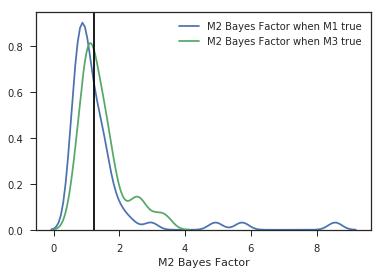

In [101]:
sns.kdeplot(chosenM2_M1true['model2_BayesFactor'], label = 'M2 Bayes Factor when M1 true');
sns.kdeplot(chosenM2_M3true['model2_BayesFactor'], label = 'M2 Bayes Factor when M3 true');
plt.xlabel('M2 Bayes Factor');
plt.axvline(float(modelFit['model2_BayesFactor']), color='black', label = 'model 2');

Proportion of Model 2 Bayes factor from real data greater than cross validation Model 2 Bayes factors incorrectly chosen when Model 1 is true

In [114]:
len(chosenM2_M1true.loc[chosenM2_M1true['model2_BayesFactor'] < float(modelFit['model2_BayesFactor'])])/chosenM2_M1true.shape[0]

0.65

Proportion of Model 2 Bayes factor from real data greater than cross validation Model 2 Bayes factors incorrectly chosen when Model 3 is true

In [115]:
len(chosenM2_M3true.loc[chosenM2_M3true['model2_BayesFactor'] < float(modelFit['model2_BayesFactor'])])/chosenM2_M3true.shape[0]

0.49333333333333335

## Correlated Stats Pruned

### Model 2

In [54]:
path = '/mnt/ABC_AJmodels_instant_newreal'
os.chdir(path)
abc_config_name = "test_ABC_correlatedstats6.txt"

[simName, obsName, outputPrefix, params_str] = read_abc_config(abc_config_name)
print(simName)

[BestSimsParamStats_name,
 MarginalPosteriorDensities_name,
 MarginalPosteriorCharacteristics_name,
 jointPosterior_name,
 MarginalPosteriorCharacteristics_reformat_name,
modelFit_name] = get_results_files(outputPrefix)
print(BestSimsParamStats_name)
print(MarginalPosteriorDensities_name)
print(jointPosterior_name)
print(MarginalPosteriorCharacteristics_reformat_name)
print(modelFit_name)

test_ABC_correlatedstats6.txt
input_ABCtoolbox_M2_HPC_OSG_2.txt
ABC_correlatedstats6_1446125_pruneCorStats_90_model0_BestSimsParamStats_Obs0.txt
ABC_correlatedstats6_1446125_pruneCorStats_90_model0_MarginalPosteriorDensities_Obs0.txt
ABC_correlatedstats6_1446125_pruneCorStats_90_model0_jointPosterior_8_9_Obs0.txt
ABC_correlatedstats6_1446125_pruneCorStats_90_model0_MarginalPosteriorCharacteristicsReformat.txt
ABC_correlatedstats6_1446125_pruneCorStats_90_modelFit.txt


#### Reformat marginal posterior densities charecterisitcs file

In [31]:
df_chrs_reformat = reformat_Characteristics(MarginalPosteriorCharacteristics_name)
df_chrs_reformat

parsing ABC_correlatedstats6_1446125_pruneCorStats_90_model0_MarginalPosteriorCharacteristics.txt


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mode,mean,median,q50_lower,q50_upper,q90_lower,q90_upper,q95_lower,q95_upper,q99_lower,q99_upper,HDI50_lower,HDI50_upper,HDI90_lower,HDI90_upper,HDI95_lower,HDI95_upper,HDI99_lower,HDI99_upper,param
0,12.909100,11.625500,11.880800,7.751050,15.633200,3.548860,18.910900,2.855900,19.416400,2.192680,19.873900,9.909090,17.580500,4.454550e+00,19.694100,3.545450e+00,19.996600,2.372300e+00,20.00000,Asc_NAF
0,9.818180,10.611900,10.433200,6.631590,14.544700,3.151130,18.545100,2.620250,19.197400,2.134590,19.820600,4.997470,12.818200,2.636360e+00,17.981400,2.272730e+00,18.803300,2.000000e+00,19.65250,Asc_NEU
0,6.000000,10.170600,9.881890,6.073830,14.107000,3.038460,18.241400,2.558760,18.999100,2.121480,19.765100,3.363640,11.033300,2.188400e+00,17.181800,2.000000e+00,18.241400,2.000000e+00,19.55160,Asc_NCHB
0,0.092424,0.083989,0.085993,0.077007,0.092687,0.062214,0.098205,0.058280,0.099057,0.052879,0.099799,0.084091,0.097815,6.759320e-02,0.100000,6.221430e-02,0.100000,5.469110e-02,0.10000,daf
0,4.395960,4.359610,4.367000,4.102230,4.617940,3.826580,4.876860,3.773960,4.928850,3.718010,4.983110,4.165990,4.678280,3.825020e+00,4.875250,3.772920e+00,4.927770,3.719710e+00,4.98471,Log10_NAF
0,4.717170,4.323550,4.398260,4.011260,4.692080,3.453390,4.925670,3.304750,4.960980,3.101250,4.991700,4.335290,4.929290,3.651200e+00,5.000000,3.453390e+00,5.000000,3.168740e+00,5.00000,Log10_NCEU
0,3.646460,3.940590,3.816390,3.547160,4.345320,3.239410,4.859430,3.155390,4.925200,3.044380,4.983900,3.343210,3.959600,3.252530e+00,4.871600,3.212120e+00,4.970490,3.079210e+00,5.00000,Log10_NCHB
0,4.195960,4.792170,4.726450,3.969520,5.630540,3.278330,6.407330,3.154920,6.537190,3.034930,6.663310,3.504540,5.089330,3.254010e+00,6.382310,3.130810e+00,6.512640,3.018690e+00,6.64620,Log10_NWA
0,5.063640,5.358740,5.346120,4.738870,5.994720,4.194260,6.516410,4.106660,6.599120,4.023730,6.677580,4.531820,5.785330,4.204550e+00,6.526110,4.122730e+00,6.614710,4.033060e+00,6.68636,Log10_NEA
0,3.129350,3.507330,3.401950,2.815180,4.100170,2.234220,5.171250,2.128770,5.503930,2.028680,6.088290,2.541150,3.773300,2.000000e+00,4.774660,2.000000e+00,5.171250,2.000000e+00,5.86673,Log10_NAg


#### Priors, truncated, and posterior distributions

In [32]:
prior = pd.read_csv(simName, sep = '\t')
prior.head()

,sim,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NANC,Log10_NCEU,Log10_NCHB,Log10_NWA,...,FST_AfAs_ASC_m,FST_EuAs_ASC,FST_eAwA_ASC,FST_eAEu_ASC,FST_eAJ_ASC,FST_eAM_ASC,FST_MJ_ASC,FST_wAEu_ASC,FST_wAJ_ASC,FST_wAM_ASC
0,0528171496036015_1151,14,17,8,0.052222,4.280442,4.002598,4.391129,4.266279,5.365600,...,0.104465,0.057020,0.002686,0.150827,0.008299,0.026635,0.024294,0.150963,0.009419,0.028186
1,0528171496034246_897,8,4,14,0.053425,4.404868,3.581722,3.123198,4.217510,6.341655,...,0.478686,0.407555,0.001390,0.297388,0.000290,0.083451,0.085553,0.299524,0.001247,0.085223
2,0528171496010621_206,3,14,2,0.078333,3.923814,3.483730,3.096910,3.823735,3.288249,...,0.339033,0.070902,0.001375,0.084863,0.008412,0.025681,0.021827,0.083589,0.008920,0.026500
3,0529171496063882_1988,7,3,7,0.072770,4.854895,4.376741,4.335538,4.876541,6.579049,...,0.059878,0.036267,-0.000017,0.027780,0.000749,0.036373,0.034299,0.029181,0.001784,0.037691
4,0529171496063882_1991,9,17,2,0.064633,4.903692,4.056524,3.635685,3.772908,5.502117,...,0.091493,0.026036,0.000894,0.067956,0.004092,0.003518,0.003223,0.066293,0.004558,0.003142


In [33]:
truncated = pd.read_csv(BestSimsParamStats_name, sep = '\t')
truncated.head()

,Sim_num,Dist,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NCEU,Log10_NCHB,Log10_NWA,...,FST_AfAs_ASC_m,FST_EuAs_ASC,FST_eAwA_ASC,FST_eAEu_ASC,FST_eAJ_ASC,FST_eAM_ASC,FST_MJ_ASC,FST_wAEu_ASC,FST_wAJ_ASC,FST_wAM_ASC
0,23,74533600.0,5,13,17,0.076029,4.26283,4.57862,3.61321,4.30494,...,0.220007,0.170124,-0.000300,0.176386,0.000825,0.001011,0.001988,0.176816,0.000408,0.001515
1,102,49229600.0,5,4,5,0.087403,4.97663,4.42085,3.01912,6.20675,...,0.267957,0.127303,0.006482,0.151521,0.018406,0.023591,0.002097,0.146635,0.016520,0.021877
2,339,39340100.0,17,3,5,0.057562,4.27655,3.31806,3.41664,6.63939,...,0.289477,0.105329,-0.000158,0.073787,0.004285,0.019499,0.025207,0.071067,0.003714,0.020997
3,405,27171100.0,10,4,7,0.062405,3.82073,4.24957,3.66717,3.08350,...,0.189929,0.124689,0.021863,0.126657,0.011762,0.013374,0.001696,0.134205,0.013356,0.016041
4,526,82716000.0,9,15,14,0.072339,4.19165,4.69258,3.83594,5.20930,...,0.072436,0.093768,-0.000451,0.101605,0.002258,0.021541,0.020686,0.100555,0.000688,0.020075


In [34]:
posterior = pd.read_csv(MarginalPosteriorDensities_name, sep = '\t')
posterior.head()

,number,Asc_NAF,Asc_NAF.density,Asc_NEU,Asc_NEU.density,Asc_NCHB,Asc_NCHB.density,daf,daf.density,Log10_NAF,...,Teu_as,Teu_as.density,TA,TA.density,TMJ,TMJ.density,TAEW,TAEW.density,Tm,Tm.density
0,1,2.00000,0.024967,2.00000,0.036374,2.00000,0.040444,0.050000,1.21222,3.70001,...,402.000,0.000601,20.0000,0.043261,21.000,0.000891,2.00000,0.019405,3.00000,0.003251
1,2,2.18182,0.026827,2.18182,0.038767,2.18182,0.043292,0.050505,1.37876,3.71314,...,439.313,0.000641,20.1616,0.045882,32.899,0.000964,2.32323,0.020870,3.32323,0.003642
2,3,2.36364,0.028650,2.36364,0.041083,2.36364,0.046060,0.051010,1.55826,3.72627,...,476.626,0.000680,20.3232,0.048396,44.798,0.001037,2.64646,0.022308,3.64646,0.004061
3,4,2.54545,0.030419,2.54545,0.043301,2.54545,0.048721,0.051515,1.75040,3.73940,...,513.939,0.000717,20.4848,0.050782,56.697,0.001109,2.96970,0.023705,3.96970,0.004510
4,5,2.72727,0.032121,2.72727,0.045402,2.72727,0.051253,0.052020,1.95468,3.75254,...,551.253,0.000751,20.6465,0.053027,68.596,0.001180,3.29293,0.025049,4.29293,0.004988


In [35]:
param_indexes = get_param_indexes(params_str)
params = get_col_names(param_indexes, prior)

In [120]:
df_chrs_reformat.head()

,mode,mean,median,q50_lower,q50_upper,q90_lower,q90_upper,q95_lower,q95_upper,q99_lower,q99_upper,HDI50_lower,HDI50_upper,HDI90_lower,HDI90_upper,HDI95_lower,HDI95_upper,HDI99_lower,HDI99_upper,param
0,14.545500,11.50710,11.581800,7.833990,15.244800,4.05975,18.639000,3.269770,19.249000,2.338410,19.832600,8.636360,16.015700,4.454550,18.99930,3.72727,19.63010,2.478260,19.90910,Asc_NAF
0,4.545450,9.64770,9.186320,5.559610,13.242200,2.81893,18.366100,2.428110,19.128700,2.090560,19.810300,3.000000,10.091900,2.000000,16.93470,2.00000,18.36610,2.000000,19.63010,Asc_NEU
0,3.636360,7.52752,6.281960,4.040560,10.171100,2.45401,16.804600,2.233170,18.073600,2.048080,19.471300,2.000000,6.281960,2.000000,14.73050,2.00000,16.80460,2.000000,19.05100,Asc_NCHB
0,0.092424,0.08572,0.088214,0.080384,0.093513,0.06360,0.098269,0.057298,0.099075,0.051566,0.099799,0.086111,0.097315,0.070449,0.10000,0.06360,0.10000,0.053022,0.10000,daf
0,4.264650,4.34555,4.333690,4.100830,4.593440,3.83715,4.870570,3.782220,4.923990,3.721040,4.981280,4.045740,4.533840,3.837890,4.87128,3.78623,4.92778,3.732840,4.99286,Log10_NAF


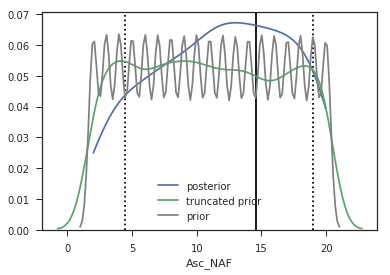

In [149]:
plot_param_densities(posterior, truncated, prior, df_chrs_reformat, 'Asc_NAF')

TypeError: cannot convert the series to <class 'float'>

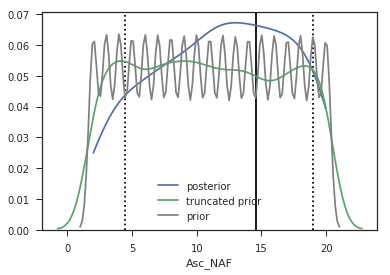

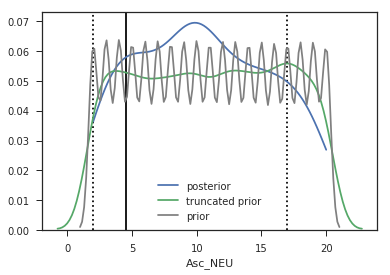

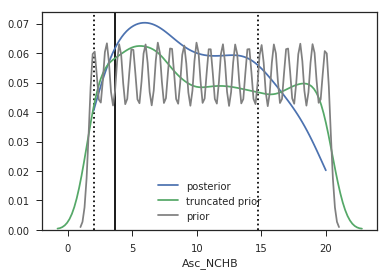

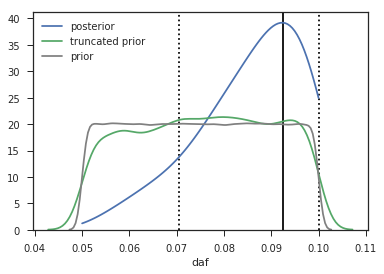

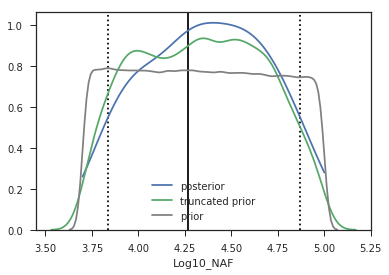

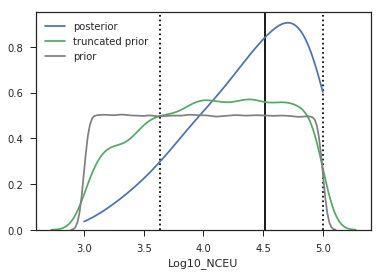

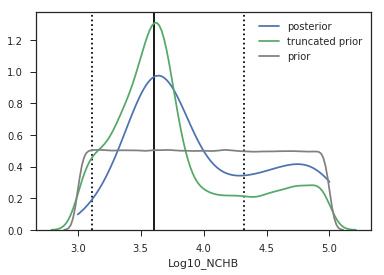

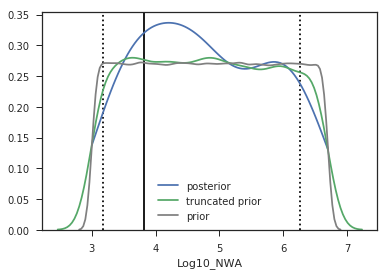

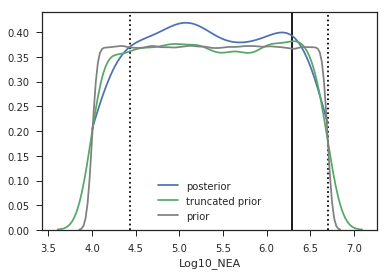

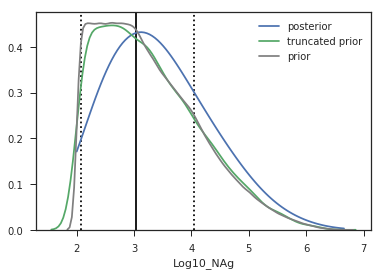

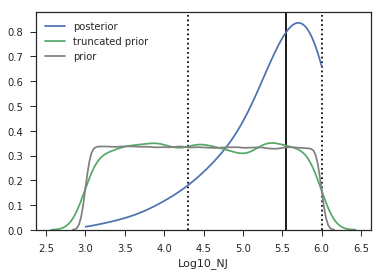

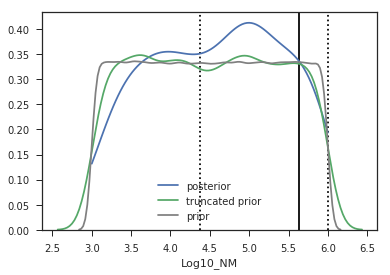

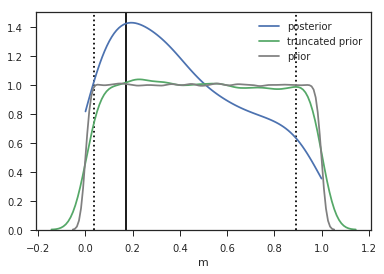

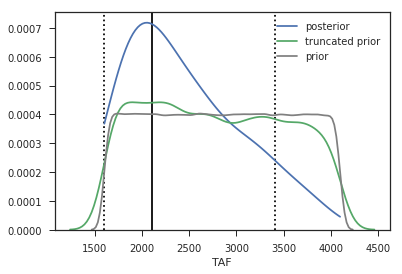

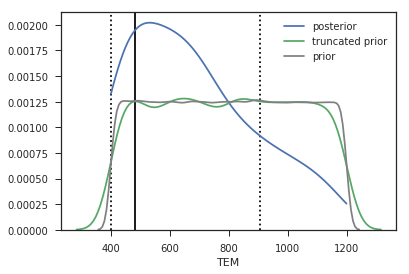

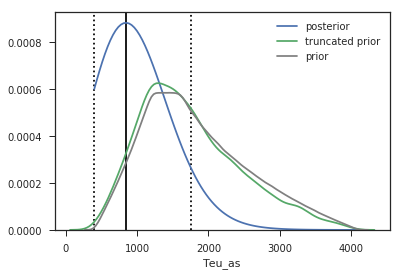

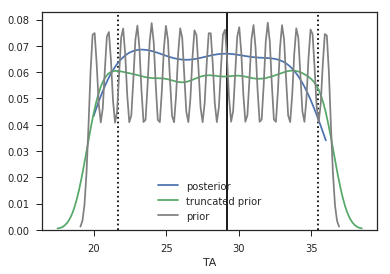

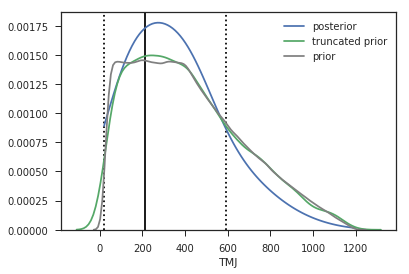

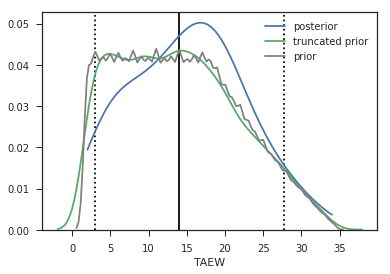

In [151]:
for param in params:
    plot_param_densities(posterior, truncated, prior, df_chrs_reformat, param)

#### Joint density plot

Create joint density dataframe

In [37]:
joint_NEA_NWA_df = create_joint_df(jointPosterior_name)
joint_NEA_NWA_df.head()

,number,Log10_NWA,Log10_NEA,density,HDI
0,0,3.00000,4.0,2.64562,0.999800
1,1,3.03737,4.0,2.88943,0.999544
2,2,3.07475,4.0,3.13849,0.999187
3,3,3.11212,4.0,3.39144,0.998674
4,4,3.14949,4.0,3.64696,0.997970


In [38]:
prob = get_prob_NEA_grtr_NWA(joint_NEA_NWA_df)
print(prob)

0.6734618390852632


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


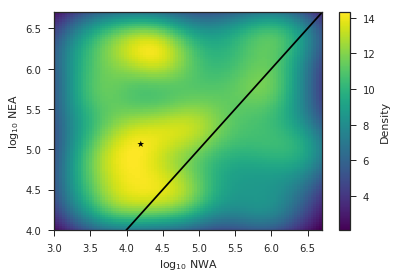

In [39]:
plot_joint_mtpltlb(joint_NEA_NWA_df, df_chrs_reformat)

## PLS

### Model 2

In [153]:
path = '/mnt/ABC_AJmodels_instant_newreal/PLS'
os.chdir(path)
abc_config_name = "test_ABC_estimate_M2_PLS.txt"

[simName, obsName, outputPrefix, params_str] = read_abc_config(abc_config_name)
print(simName)

[BestSimsParamStats_name,
 MarginalPosteriorDensities_name,
 MarginalPosteriorCharacteristics_name,
 jointPosterior_name,
 MarginalPosteriorCharacteristics_reformat_name,
modelFit] = get_results_files(outputPrefix)
print(BestSimsParamStats_name)
print(MarginalPosteriorDensities_name)
print(jointPosterior_name)
print(MarginalPosteriorCharacteristics_reformat_name)

test_ABC_estimate_M2_PLS.txt
input_ABCtoolbox_M2_HPC_OSG_2.transformed_10pls.txt
ABC_M2_estimate_1446125_10pls_1000ret_model0_BestSimsParamStats_Obs0.txt
ABC_M2_estimate_1446125_10pls_1000ret_model0_MarginalPosteriorDensities_Obs0.txt
ABC_M2_estimate_1446125_10pls_1000ret_model0_jointPosterior_8_9_Obs0.txt
ABC_M2_estimate_1446125_10pls_1000ret_model0_MarginalPosteriorCharacteristicsReformat.txt


In [154]:
param_indexes = get_param_indexes(params_str)
params = get_col_names(param_indexes, prior)

#### Reformat marginal posterior densities charecterisitcs file

In [155]:
df_chrs_reformat = reformat_Characteristics(MarginalPosteriorCharacteristics_name)
df_chrs_reformat

parsing ABC_M2_estimate_1446125_10pls_1000ret_model0_MarginalPosteriorCharacteristics.txt


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mode,mean,median,q50_lower,q50_upper,q90_lower,q90_upper,q95_lower,q95_upper,q99_lower,q99_upper,HDI50_lower,HDI50_upper,HDI90_lower,HDI90_upper,HDI95_lower,HDI95_upper,HDI99_lower,HDI99_upper,param
0,14.545500,11.507100,11.581800,7.833990,15.244800,4.059750,18.639000,3.269770,19.249000,2.338410,19.832600,8.636360,16.015700,4.454550,18.999300,3.727270,19.630100,2.478260,19.909100,Asc_NAF
0,4.545450,9.647700,9.186320,5.559610,13.242200,2.818930,18.366100,2.428110,19.128700,2.090560,19.810300,3.000000,10.091900,2.000000,16.934700,2.000000,18.366100,2.000000,19.630100,Asc_NEU
0,3.636360,7.527520,6.281960,4.040560,10.171100,2.454010,16.804600,2.233170,18.073600,2.048080,19.471300,2.000000,6.281960,2.000000,14.730500,2.000000,16.804600,2.000000,19.051000,Asc_NCHB
0,0.092424,0.085720,0.088214,0.080384,0.093513,0.063600,0.098269,0.057298,0.099075,0.051566,0.099799,0.086111,0.097315,0.070449,0.100000,0.063600,0.100000,0.053022,0.100000,daf
0,4.264650,4.345550,4.333690,4.100830,4.593440,3.837150,4.870570,3.782220,4.923990,3.721040,4.981280,4.045740,4.533840,3.837890,4.871280,3.786230,4.927780,3.732840,4.992860,Log10_NAF
0,4.515150,4.296760,4.375370,4.026410,4.628990,3.440850,4.886250,3.295160,4.936280,3.094230,4.985540,4.222730,4.767680,3.637790,5.000000,3.440850,5.000000,3.159870,5.000000,Log10_NCEU
0,3.606060,3.735400,3.678890,3.473980,3.930530,3.218460,4.487120,3.147530,4.669080,3.046380,4.904190,3.399960,3.838380,3.116890,4.323230,3.070710,4.540970,3.000000,4.831070,Log10_NCHB
0,3.822220,4.770340,4.763500,3.913370,5.599660,3.253330,6.363910,3.140650,6.509950,3.031620,6.655990,3.504540,5.183300,3.168180,6.266120,3.056060,6.413580,3.000000,6.615650,Log10_NWA
0,6.290910,5.472030,5.499300,4.869100,6.114450,4.245900,6.556460,4.134900,6.623170,4.030210,6.683370,5.391160,6.577270,4.436600,6.700000,4.245900,6.700000,4.058450,6.700000,Log10_NEA
0,3.035240,3.151810,3.101220,2.699010,3.546250,2.229210,4.275120,2.130100,4.527540,2.030020,5.017240,2.598800,3.435220,2.070580,4.047810,2.000000,4.275120,2.000000,4.820920,Log10_NAg


#### Priors, truncated, and posterior distributions

In [156]:
prior_pls = pd.read_csv(simName, sep = '\t')
prior_pls.head()

,sim,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NANC,Log10_NCEU,Log10_NCHB,Log10_NWA,...,LinearCombination_0,LinearCombination_1,LinearCombination_2,LinearCombination_3,LinearCombination_4,LinearCombination_5,LinearCombination_6,LinearCombination_7,LinearCombination_8,LinearCombination_9
0,5.281710e+14,14,17,8,0.052222,4.28044,4.00260,4.39113,4.26628,5.36560,...,1.125010,0.86040,2.423170,-1.240080,0.845003,-1.125590,0.981563,-3.112930,-2.369540,1.570150
1,5.281710e+14,8,4,14,0.053426,4.40487,3.58172,3.12320,4.21751,6.34165,...,10.571300,-7.41682,4.473280,-0.965474,4.215160,-0.527522,1.450910,-3.491500,-3.786360,2.616750
2,5.281710e+14,3,14,2,0.078333,3.92381,3.48373,3.09691,3.82373,3.28825,...,-5.533650,-3.17681,-4.261020,-1.686030,2.272880,1.961840,-1.393840,-0.596993,-0.301039,0.893576
3,5.291710e+14,7,3,7,0.072770,4.85489,4.37674,4.33554,4.87654,6.57905,...,-9.785690,4.81581,-0.450111,-0.057790,1.622090,-1.117200,-0.433007,0.778963,-0.293196,-0.013859
4,5.291710e+14,9,17,2,0.064633,4.90369,4.05652,3.63568,3.77291,5.50212,...,0.886967,4.40390,1.310930,1.441910,0.822246,-0.875576,0.238202,-4.099040,-1.115370,1.816170


In [157]:
truncated_pls = pd.read_csv(BestSimsParamStats_name, sep = '\t')
truncated_pls.head()

,Sim_num,Dist,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NCEU,Log10_NCHB,Log10_NWA,...,LinearCombination_0,LinearCombination_1,LinearCombination_2,LinearCombination_3,LinearCombination_4,LinearCombination_5,LinearCombination_6,LinearCombination_7,LinearCombination_8,LinearCombination_9
0,264,16.8687,8,15,8,0.097583,3.93671,4.35744,4.06247,5.20517,...,-14.4694,0.878387,-5.08654,1.787270,3.31941,3.30940,1.75454,1.881890,-1.808710,-2.009360
1,1117,15.8772,19,3,20,0.098055,4.92612,4.05835,3.89597,4.36596,...,-14.1798,0.576015,-4.30848,1.535540,2.54265,2.58288,1.78050,1.356290,0.131996,-2.163160
2,1178,15.7531,16,6,19,0.097908,4.43821,4.94385,4.28883,5.64311,...,-13.6000,0.248529,-5.32594,0.187016,2.82822,3.45323,2.10797,0.942264,-1.200940,-2.999570
3,2635,13.8534,6,3,4,0.097245,4.77986,3.89840,3.92355,5.42171,...,-12.5832,0.729135,-2.31277,1.542970,3.18700,2.62611,1.40639,1.475900,-0.904433,-0.654759
4,3373,16.4925,5,7,4,0.077518,4.52802,3.82230,3.36342,6.30811,...,-13.6125,-2.511240,-1.17663,2.896810,3.33754,4.47957,1.29533,2.474460,-0.298918,-1.051090


In [158]:
posterior_pls = pd.read_csv(MarginalPosteriorDensities_name, sep = '\t')
posterior_pls.head()

,number,Asc_NAF,Asc_NAF.density,Asc_NEU,Asc_NEU.density,Asc_NCHB,Asc_NCHB.density,daf,daf.density,Log10_NAF,...,Teu_as,Teu_as.density,TA,TA.density,TMJ,TMJ.density,TAEW,TAEW.density,Tm,Tm.density
0,1,2.00000,0.013209,2.00000,0.055210,2.00000,0.103986,0.050000,3.01493,3.70001,...,402.000,0.000592,20.0000,0.034464,21.000,0.001136,2.00000,0.017954,3.00000,0.001714
1,2,2.18182,0.014878,2.18182,0.058040,2.18182,0.109286,0.050505,3.14045,3.71314,...,439.313,0.000638,20.1616,0.036640,32.899,0.001226,2.32323,0.019395,3.32323,0.001995
2,3,2.36364,0.016658,2.36364,0.060677,2.36364,0.114057,0.051010,3.24845,3.72627,...,476.626,0.000682,20.3232,0.038716,44.798,0.001315,2.64646,0.020832,3.64646,0.002310
3,4,2.54545,0.018543,2.54545,0.063102,2.54545,0.118236,0.051515,3.33815,3.73940,...,513.939,0.000724,20.4848,0.040669,56.697,0.001400,2.96970,0.022254,3.96970,0.002661
4,5,2.72727,0.020521,2.72727,0.065299,2.72727,0.121775,0.052020,3.40941,3.75253,...,551.253,0.000763,20.6465,0.042482,68.596,0.001481,3.29293,0.023649,4.29293,0.003049


TypeError: cannot convert the series to <class 'float'>

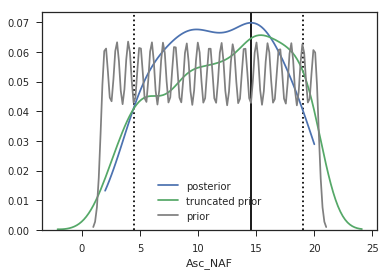

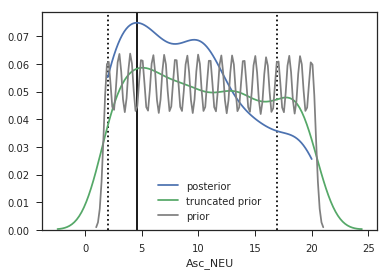

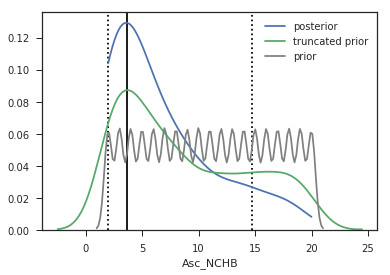

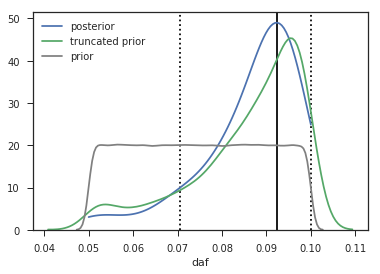

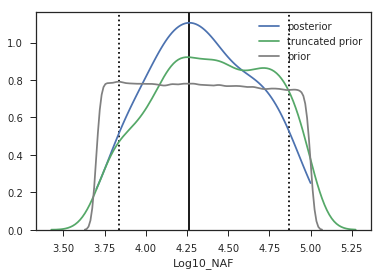

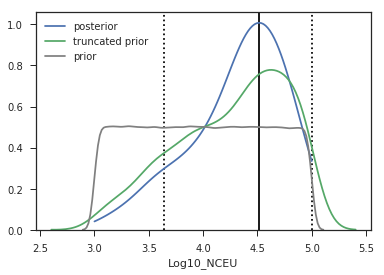

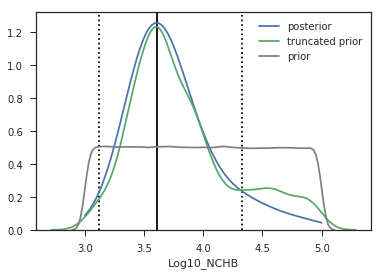

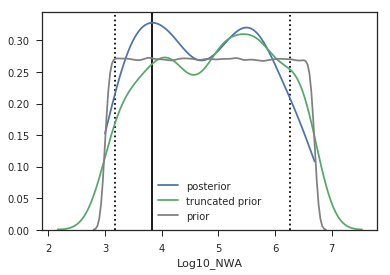

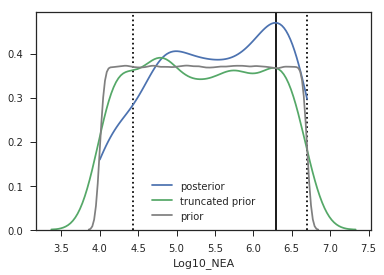

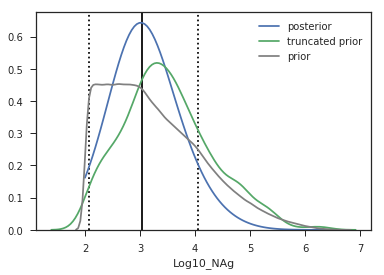

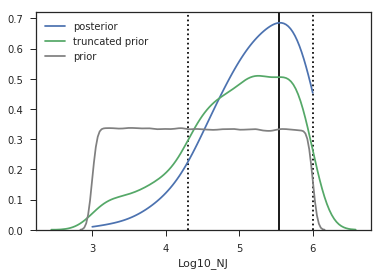

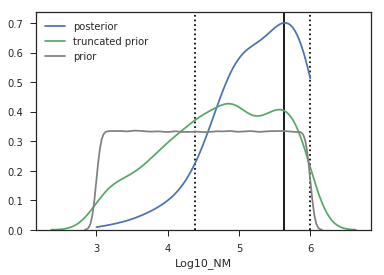

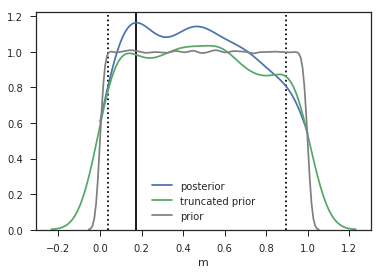

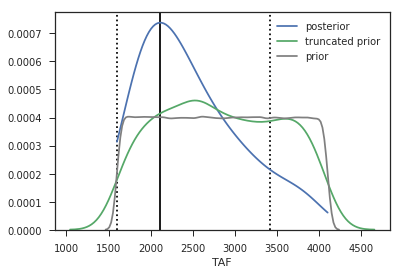

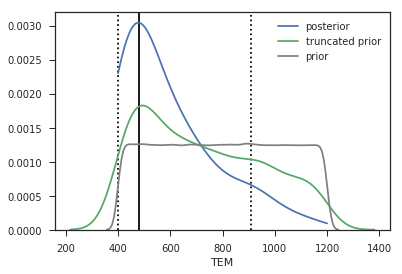

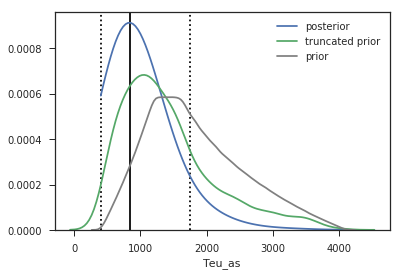

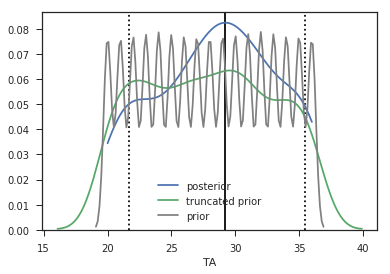

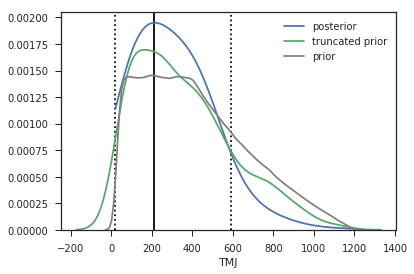

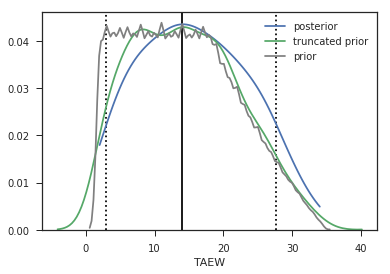

In [160]:
for param in params:
    plot_param_densities(posterior_pls, truncated_pls, prior_pls, df_chrs_reformat, param)

#### Joint density plot

Create joint density dataframe

In [47]:
joint_NEA_NWA_df_pls = create_joint_df(jointPosterior_name)
joint_NEA_NWA_df_pls.head()

,number,Log10_NWA,Log10_NEA,density,HDI
0,0,3.00000,4.0,2.89802,0.997282
1,1,3.03737,4.0,3.07695,0.996633
2,2,3.07475,4.0,3.24135,0.995827
3,3,3.11212,4.0,3.38884,0.995046
4,4,3.14949,4.0,3.51763,0.994341


In [48]:
prob = get_prob_NEA_grtr_NWA(joint_NEA_NWA_df_pls)
print(prob)

0.6848261120381732


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:176: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


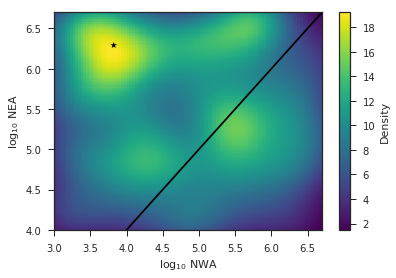

In [49]:
plot_joint_mtpltlb(joint_NEA_NWA_df_pls, df_chrs_reformat)